In [14]:
%autosave 5
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy
import astropy.units as u
from astropy import wcs
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.visualization import astropy_mpl_style
from photutils import DAOStarFinder

Autosaving every 5 seconds


 [astropy.io.fits.verify]


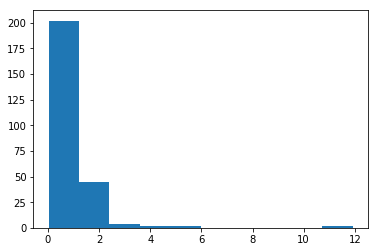

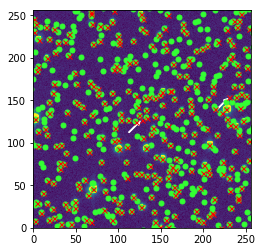

In [44]:
master = fits.open('MASTER.fit')[0]

mean, median, std = sigma_clipped_stats(master.data)
starfind = DAOStarFinder(threshold=5.*std, fwhm=3)
sources = starfind(master.data - median)

w = wcs.WCS(master.header)
wcs.utils.pixel_to_skycoord
coords = wcs.utils.pixel_to_skycoord(
    sources['xcentroid'],
    sources['ycentroid'],
    w
)
center_coord = wcs.utils.pixel_to_skycoord(
    master.data.shape[0]/2,
    master.data.shape[1]/2,
    w
)

vizier = Vizier(
    column_filters={"Bmag":"<20"},
    row_limit=1000
)
usno_sources = vizier.query_region(
    center_coord,
    radius=6*u.arcmin,
    catalog='USNO-A2.0',
)[0]
usno_coords = SkyCoord(
    ra=usno_sources['RAJ2000'],
    dec=usno_sources['DEJ2000'],
    unit=u.deg,
)
usno_pixels = wcs.utils.skycoord_to_pixel(
    usno_coords,
    w
)

idx, sep2d, _ = coords.match_to_catalog_sky(
    usno_coords
)
targets = sources[sep2d > 7*u.arcsec]

plt.hist(sep2d.to_value(u.arcsec))

plt.figure()
plt.xlim([0, master.data.shape[0]])
plt.ylim([0, master.data.shape[1]])
plt.imshow(
    master.data,
    origin='lower',
    norm=LogNorm(vmax=2000)
)
for x, y in zip(*usno_pixels):
    plt.plot(x, y, 'o', color='#33ff33', ms=5)
for source in sources:
    plt.plot(
        source['xcentroid'],
        source['ycentroid'],
        'rx',
        ms=5,
    )
for target in targets:
    plt.arrow(
        target['xcentroid'] - 15,
        target['ycentroid'] - 15,
        15-5, 1505,
        width=1, head_width=5, head_length=5,
        fc='w', ec='w'
    )